In [46]:
# Step 1: Install required libraries
# !pip install transformers datasets

# Step 2: Import libraries and load the dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import EarlyStoppingCallback


In [28]:
# Load the dataset
file_path = "Symptom2Disease.csv"
data = pd.read_csv(file_path)
print(data.head())

   Unnamed: 0      label                                               text
0           0  Psoriasis  I have been experiencing a skin rash on my arm...
1           1  Psoriasis  My skin has been peeling, especially on my kne...
2           2  Psoriasis  I have been experiencing joint pain in my fing...
3           3  Psoriasis  There is a silver like dusting on my skin, esp...
4           4  Psoriasis  My nails have small dents or pits in them, and...


In [29]:
symptoms = data['text']
diseases = data['label']

# Encode disease labels
label_encoder = LabelEncoder()
data['disease_encoded'] = label_encoder.fit_transform(diseases)
temp_texts, test_texts, temp_labels, test_labels = train_test_split(symptoms, data['disease_encoded'], test_size=0.2, random_state=42)
train_texts, val_texts, train_labels, val_labels = train_test_split(temp_texts, temp_labels, test_size=0.25, random_state=42)


In [30]:
# Step 4: Tokenize the input data
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Ensure padding token is set

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)


In [31]:
# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': list(train_labels)})
val_dataset = Dataset.from_dict({'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask'], 'labels': list(val_labels)})


In [32]:
# Step 5: Load GPT-2 model and adapt for classification
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=len(label_encoder.classes_))

# Set the pad_token_id to the EOS token ID
# Assuming you have a tokenizer named 'tokenizer' initialized previously
if model.config.pad_token_id is None:
    model.config.pad_token_id = tokenizer.eos_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
# Step 6: Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=9,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

In [34]:
# Step 7: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

In [35]:
# Step 8: Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,3.752300,3.550076
2,2.668300,2.760318
3,1.763200,1.428913
4,0.962600,0.935835
5,0.557000,0.465683
6,0.187600,0.350526
7,0.080400,0.439032
8,0.006200,0.240822
9,0.008400,0.242806


TrainOutput(global_step=855, training_loss=1.6468624584507523, metrics={'train_runtime': 382.2271, 'train_samples_per_second': 17.824, 'train_steps_per_second': 2.237, 'total_flos': 243463455406080.0, 'train_loss': 1.6468624584507523, 'epoch': 9.0})

In [36]:
# Step 9: Evaluate the model
results = trainer.evaluate()
print(results)

# Step 10: Save the model and tokenizer
model.save_pretrained('./gpt2-disease-prediction')
tokenizer.save_pretrained('./gpt2-disease-prediction')

{'eval_loss': 0.2408216893672943, 'eval_runtime': 0.9413, 'eval_samples_per_second': 268.778, 'eval_steps_per_second': 8.499, 'epoch': 9.0}


('./gpt2-disease-prediction/tokenizer_config.json',
 './gpt2-disease-prediction/special_tokens_map.json',
 './gpt2-disease-prediction/vocab.json',
 './gpt2-disease-prediction/merges.txt',
 './gpt2-disease-prediction/added_tokens.json')

Evaluation and testing

In [37]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import numpy as np

# Step 1: Prepare the test dataset
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': list(test_labels),
})

In [38]:
# Step 2: Evaluate the model using built-in metrics
results = trainer.evaluate(eval_dataset=test_dataset)
print("Evaluation Results:", results)

Evaluation Results: {'eval_loss': 0.4052826166152954, 'eval_runtime': 0.9114, 'eval_samples_per_second': 277.591, 'eval_steps_per_second': 8.778, 'epoch': 9.0}


In [39]:
# Step 3: Generate predictions
# Make predictions
raw_predictions = trainer.predict(test_dataset)
predictions = np.argmax(raw_predictions.predictions, axis=1)
true_labels = test_labels

In [40]:
# Step 4: Calculate custom metrics
# Accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import numpy as np


accuracy = accuracy_score(true_labels, predictions)
print("Accuracy:", accuracy)

# Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average="weighted")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Classification Report (for detailed metrics per class)
# Get the unique labels from true_labels and predictions
unique_labels = np.unique(np.concatenate((true_labels, predictions)))

# Generate the classification report using the unique labels
class_report = classification_report(true_labels, predictions, labels=unique_labels, target_names=label_encoder.classes_[unique_labels] if label_encoder is not None else None)
print("Classification Report:\n", class_report)

Accuracy: 0.932806324110672
Precision: 0.9151, Recall: 0.9328, F1-Score: 0.9194
Classification Report:
                                  precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00        17
            Alzheimer's Disease       0.00      0.00      0.00         1
                Aplastic Anemia       1.00      1.00      1.00         2
                      Arthritis       1.00      1.00      1.00        10
               Bronchial Asthma       0.89      1.00      0.94         8
                 Celiac Disease       0.00      0.00      0.00         2
           Cervical spondylosis       1.00      1.00      1.00         7
                    Chicken pox       0.91      0.91      0.91        11
       Chronic Fatigue Syndrome       0.00      0.00      0.00         3
                    Common Cold       1.00      0.90      0.95        10
                         Dengue       0.86      0.86      0.86        14
          Dimorphic

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [53]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k = 24)
pred1 = pipe("rashes on my skin")
pred2 = pipe("I have constipation and belly pain, and it's been really uncomfortable. The belly pain has been getting worse and is starting to affect my daily life. Moreover, I get chills every night, followed by a mild fever.")


print(pred1[0][:2])
print(pred2[0][:2])

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'LABEL_31', 'score': 0.5930856466293335}, {'label': 'LABEL_1', 'score': 0.10528857260942459}]
[{'label': 'LABEL_27', 'score': 0.9998321533203125}, {'label': 'LABEL_18', 'score': 8.306624658871442e-05}]


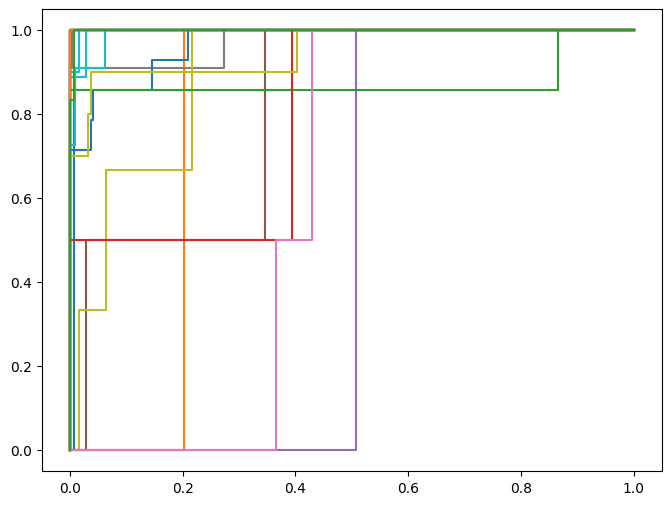

In [59]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Step 1: Binarize the true labels
true_labels_bin = label_binarize(true_labels, classes=np.arange(len(label_encoder.classes_)))

# Step 2: Calculate the ROC curve and AUC for each class
fpr, tpr, thresholds = {}, {}, {}
roc_auc = {}

# Loop through each class
for i in range(len(label_encoder.classes_)):
    # Check if the class is present in the true labels
    if np.any(true_labels_bin[:, i]):  # If there are positive labels for this class
        fpr[i], tpr[i], thresholds[i] = roc_curve(true_labels_bin[:, i], raw_predictions.predictions[:, i])
        roc_auc[i] = roc_auc_score(true_labels_bin[:, i], raw_predictions.predictions[:, i])

# Step 3: Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    if i in roc_auc:  # Only plot the class if ROC AUC is available (i.e., if there are positive labels)
        plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal (no discrimination)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Multi-Class Classification')
# plt.legend(loc='lower right')
# plt.show()

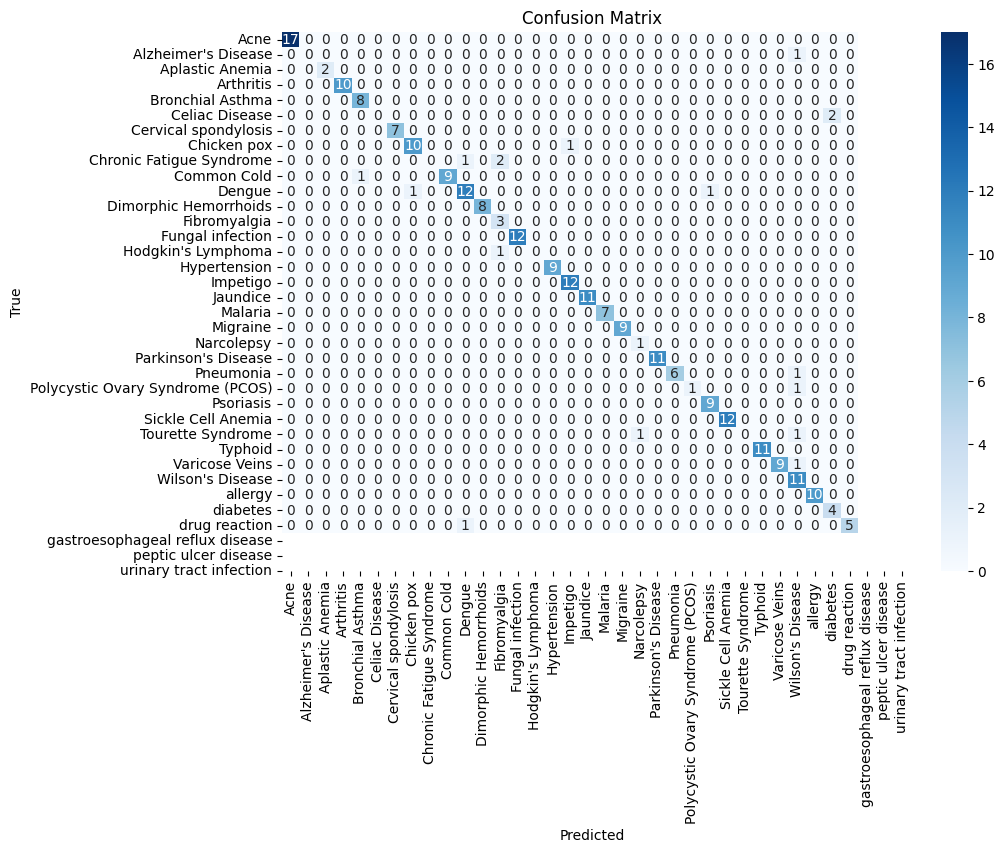

ValueError: multilabel-indicator format is not supported

In [61]:
# Step 16: Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Step 18: Precision-Recall Curve
precision, recall, _ = precision_recall_curve(true_labels_bin, predictions)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Step 19: Learning Curve (optional visualization of loss over training)
logs = trainer.state.log_history
train_loss = [log['loss'] for log in logs if 'loss' in log]
val_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]

plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Learning Curve")
plt.show()

# Step 20: Disease Distribution Plot
data['label'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Disease')
plt.ylabel('Frequency')
plt.title('Disease Distribution')
plt.xticks(rotation=90)
plt.show()
